# Notebook with Face Detection Attempts
© ~~Обучить~~ нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек.

In [1]:
import random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cpu


In [2]:
# Download picture with people
!gdown 1pivRzStoQgPlFBvjRwda6zvkjLHr_yYp

Downloading...
From: https://drive.google.com/uc?id=1pivRzStoQgPlFBvjRwda6zvkjLHr_yYp
To: /kaggle/working/IMG_20250103_175906_259.jpg
100%|████████████████████████████████████████| 174k/174k [00:00<00:00, 73.5MB/s]


In [3]:
# Package for face detection
!pip install --no-deps facenet-pytorch
import warnings
warnings.filterwarnings("ignore") 

from facenet_pytorch import MTCNN
detector = MTCNN()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.7 MB/s eta 0:00:0000:01


## Detect faces

In [4]:
img = read_image('/kaggle/working/IMG_20250103_175906_259.jpg')
np_img = torch.permute(img, (1, 2, 0)).numpy()

# Detect faces
boxes, probs, landmarks = detector.detect(np_img, landmarks=True)

detected = pd.DataFrame({'boxes': boxes.tolist(), 'probs': probs.tolist(), 'landmarks': landmarks.tolist()})
detected = detected[detected['probs'] > 0.95]
boxes, probs, landmarks = detected['boxes'], detected['probs'], detected['landmarks']

In [5]:
def render_tensor(img, device, boxes=None, probs=None, landmarks=None):
    # Display the image
    if str(device) == 'cuda':
        plt.imshow(torch.permute(img, (1, 2, 0)).cpu())
    else:
        plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.axis('off')
    
    # Iterate through provided overlays
    if boxes is not None:
        ax = plt.gca()
        clrs = ['b', 'g', 'r', 'c', 'm', 'y']
        
        for i, box in enumerate(boxes):
            color = random.choice(clrs)
            rect = Rectangle(
                (box[0], box[1]), # x, y
                box[2]-box[0], box[3]-box[1], # width, height
                linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
                
            if probs is not None:
                prob = probs[i]
                ax.text(
                    box[0], box[1], # x, y
                    f"{(100*prob):.0f}%", # text
                    fontsize=8, color=color, weight='bold',
                    bbox=dict(fill=False, linewidth=0))
        
            if landmarks is not None:
                landmark = landmarks[i]
                ax.scatter(
                    np.array(landmark)[:, 0], # xs
                    np.array(landmark)[:, 1], # ys
                    s=2, color=color)
    
    plt.show()
    return

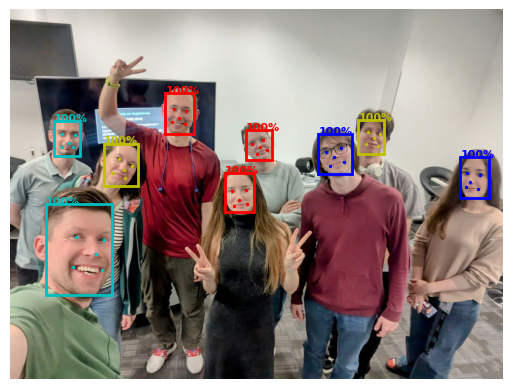

In [6]:
render_tensor(
    img, DEVICE,
    boxes=boxes,
    probs=probs,
    landmarks=landmarks
)

## Extract face(s)

In [7]:
def extract_face(img, box, landmark):
    new_landmark = []
    for dot in landmark:
        new_x = int(dot[0]-box[0])
        new_y = int(dot[1]-box[1])
        new_landmark.append([new_x, new_y])

    box = list(map(int, box))

    if isinstance(img, np.ndarray):
        face = img[box[1]:box[3], box[0]:box[2], :]
        face = torch.Tensor(face).type(torch.uint8)
    elif isinstance(img, torch.Tensor):
        face = img[:, box[1]:box[3], box[0]:box[2]]
        face = face.permute((1,2,0))
    else:
        raise Exception("Got not torch.Tensor nor numpy.ndarray")

    new_landmark = torch.Tensor(new_landmark)
    new_landmark = new_landmark.repeat(1, 2)
    new_landmark = tv_tensors.BoundingBoxes(
        new_landmark, format='XYXY', canvas_size=face.shape[:2]
    )
    
    return {'image': face, 'landmarks': new_landmark}

image for extraction type: <class 'numpy.ndarray'>
Extracting the face...
Face shape: torch.Size([104, 89, 3])


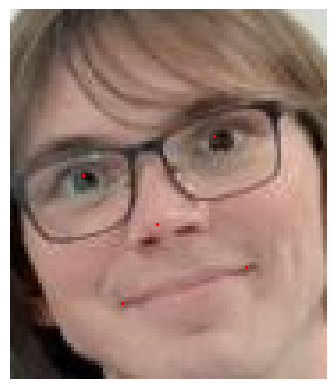

Landmarks:
BoundingBoxes([[20., 46., 20., 46.],
               [57., 35., 57., 35.],
               [41., 60., 41., 60.],
               [31., 82., 31., 82.],
               [66., 72., 66., 72.]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([104, 89]))


In [8]:
# extract face from numpy ndarray
print(f"image for extraction type: {type(np_img)}")
print("Extracting the face...")
face = extract_face(np_img, boxes[2], landmarks[2])

print(f"Face shape: {face['image'].shape}")
plt.imshow(face['image'])

ax = plt.gca()
ax.scatter(face['landmarks'][:, 0], face['landmarks'][:, 1], s=2, color='r')
plt.axis('off')
plt.show()
print(f"Landmarks:\n{face['landmarks']}")

image for extraction type: <class 'torch.Tensor'>
Extracting the face...
Face shape: torch.Size([104, 89, 3])


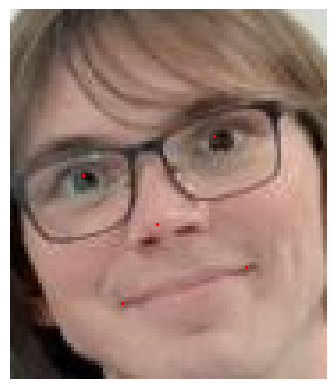

Landmarks:
BoundingBoxes([[20., 46., 20., 46.],
               [57., 35., 57., 35.],
               [41., 60., 41., 60.],
               [31., 82., 31., 82.],
               [66., 72., 66., 72.]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([104, 89]))


In [9]:
# extract face from torch tensor (PREFERED)
print(f"image for extraction type: {type(img)}")
print("Extracting the face...")
face = extract_face(img, boxes[2], landmarks[2])

print(f"Face shape: {face['image'].shape}")
plt.imshow(face['image'])

ax = plt.gca()
ax.scatter(face['landmarks'][:, 0], face['landmarks'][:, 1], s=2, color='r')
plt.axis('off')
plt.show()
print(f"Landmarks:\n{face['landmarks']}")

## Align the face

### Check faces save their landmarks after transformations

In [10]:
transforms = v2.Compose([
    v2.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.1),
    v2.RandomAdjustSharpness(sharpness_factor=4, p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(-10, 10)),
    v2.RandomAffine(degrees=0, scale=(0.9, 1.1)),
])

In [11]:
# Живём в парадигме, что face - это всегда словарь с двумя ключами:
# 'image', и значение для которого торчовый тензор [HxWxC];
# 'landmarks', значение для которого ключевые точки (трансформирующиеся вместе с image)

transformed_faces = [
    {'image': face['image'], 'landmarks': face['landmarks']}
]

for i in range(4):
    transformed_face = transforms(face['image'].permute(2,0,1), face['landmarks'])
    transformed_faces.append(
        {'image': transformed_face[0].permute(1,2,0), 'landmarks': transformed_face[1]}
    )

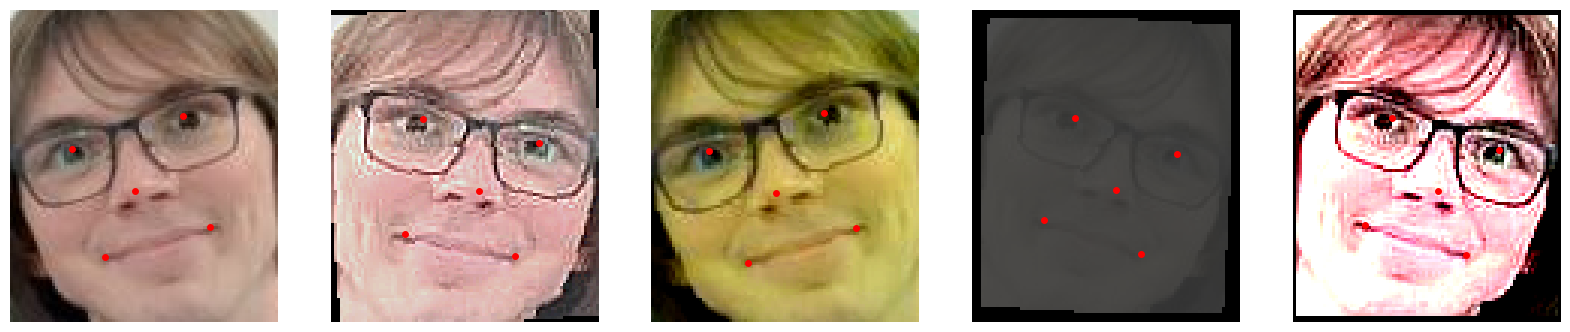

In [12]:
plt.figure(figsize=[20, 7])

for i in range(len(transformed_faces)):
    plt.subplot(1, len(transformed_faces), i+1)
    plt.imshow(transformed_faces[i]['image'])

    ax = plt.gca()
    ax.scatter(transformed_faces[i]['landmarks'][:, 0], transformed_faces[i]['landmarks'][:, 1], s=16, color='r')
    plt.axis('off')

In [13]:
# Write some functions for align. Their names speak for themselves
def calculate_angle_to_rotate(face):
    """
    face is _always_ a dict with to keys: 'image', 'landmarks'
    face['image'] -> torch.Tensor [HxWxC]
    face['landmarks'] -> tv_tensors.BoundingBoxes [5x4] (format 'XYXY')
    """
    shape_y = face['image'].size(0)
    shape_x = face['image'].size(1)
    center = shape_x//2, shape_y//2

    eye1_x, eye1_y = face['landmarks'][0][0], face['landmarks'][0][1]
    eye2_x, eye2_y = face['landmarks'][1][0], face['landmarks'][1][1]

    coside = eye2_x - eye1_x
    verside = eye2_y - eye1_y
    tan = verside/ coside
    angle = torch.atan(tan)

    angle_in_degrees = 180 * angle / torch.pi
    
    return angle_in_degrees
    
def align_face(face):
    """
    face is _always_ a dict with to keys: 'image', 'landmarks'
    face['image'] -> torch.Tensor [HxWxC]
    face['landmarks'] -> tv_tensors.BoundingBoxes [5x4] (format 'XYXY')
    """
    angle = calculate_angle_to_rotate(face)
    rotation = v2.RandomRotation(degrees=(angle, angle))
    aligned_face_tuple = rotation(face['image'].permute(2,0,1), face['landmarks'])
    aligned_face = {
        'image': aligned_face_tuple[0].permute(1,2,0),
        'landmarks': aligned_face_tuple[1]
    }

    return aligned_face    

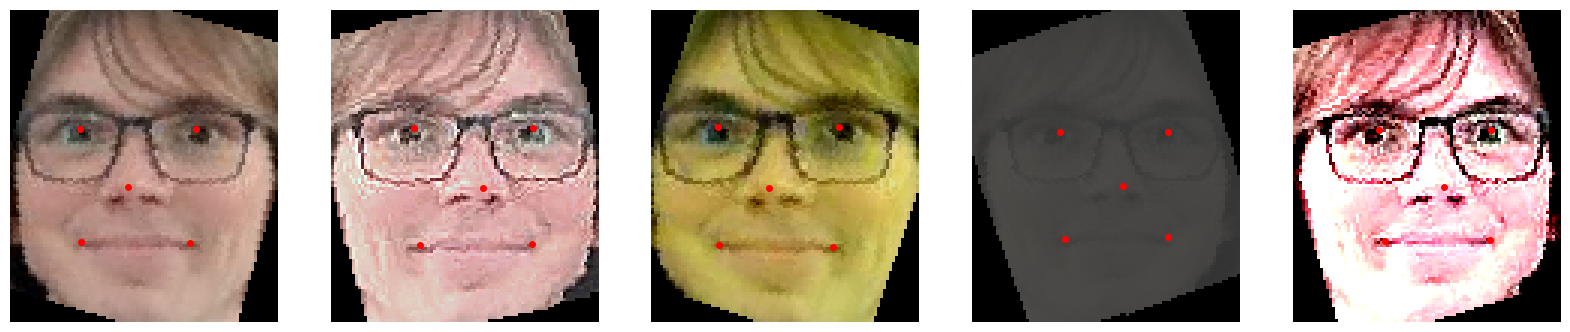

In [14]:
aligned_faces = []
for i in range(len(transformed_faces)):
    aligned_faces.append(align_face(transformed_faces[i]))

plt.figure(figsize=[20, 7])

for i in range(len(aligned_faces)):
    plt.subplot(1, 5, i+1)
    plt.imshow(aligned_faces[i]['image'])

    ax = plt.gca()
    ax.scatter(aligned_faces[i]['landmarks'][:, 0], aligned_faces[i]['landmarks'][:, 1], s=16, color='r')
    plt.axis('off')

In [15]:
display(face['image'].shape)
display(transformed_faces[0]['image'].shape)
display(aligned_faces[0]['image'].shape)

torch.Size([104, 89, 3])

torch.Size([104, 89, 3])

torch.Size([104, 89, 3])